In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import pickle
import json
import numpy as np
import matplotlib as mpl
import os

In [2]:
mpl.style.use('seaborn-v0_8-colorblind')
plt.rcParams["font.family"] = "serif"

### 3.1 Experiments

In [ ]:
models = ["hyperprior", "mbt2018", "cheng2020-attn", "qres17m", "qarv"]
model_names = ["Hyperprior", "Joint", "GaussianMix-Attn", "QRes", "VarQRes"]
races = ['Indian', 'Asian', 'African', 'Caucasian']
qualities = ["q_0001", "q_0009", "q_1", "q_2", "q_3"]
categories = ['skin_type', 'eye_type', 'nose_type', 'lip_type', 'hair_type', 'hair_color']
category_names = ['Skin Type', 'Eye Type', 'Nose Type', 'Lip Type', 'Hair Type', 'Hair Color']
qres = ["1", "3", "6", "9", "12"]
qarv = ["lmb_1", "lmb_4", "lmb_8", "lmb_16", "lmb_32" ]
markers = ['s', 'o', '^', '*', 'D']
linestyles = ['solid', 'dashed', 'dashdot', 'dotted', "dotted"]

In [ ]:
## for a model and generate accuracies for all rates
def generate_results(dataset="celebA", model="hyperprior"):
    rates = []
    results = {}
    for i, q in enumerate(qualities):
        results[q] = {}
        #Iterate through qualities and pull dictionaries
        with open(f'/media/global_data/fair_neural_compression_data/final_predictions/{model}/{dataset}/{q}/sep_predictions.pkl', 'rb') as f:
            all_predictions = pickle.load(f)
        with open(f'/media/global_data/fair_neural_compression_data/final_predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
            all_labels = pickle.load(f)
        
        if model == "qarv":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qarv/celebA/{qarv[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']
            pass
        elif model == "qres17m":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qres17m_lmb_64/celebA/{qres[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']
        else:
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/{model}/{dataset}/{q}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['est_bpp']
        rates.append(bpp)
        merged_skin_type={
              'African':([4, 5], 3), 
              'Asian':([3, 2], 1), 
              'Caucasian':([3, 2], 1), 
              'Indian':([4,3], 2)
        }
        merged_hair_type={
                'African':([1, 3], 0), 
                'Asian':([2, 3], 0), 
                'Caucasian':([2, 3], 0), 
                'Indian':([2, 3], 0)
        }
        merged_hair_color={
                'African':([2, 3], 0), 
                'Asian':([2, 3], 0), 
                'Caucasian':([1, 2], 0), 
                'Indian':([2, 3], 0)
        }
        for race in races:
            results[q][race] = {}
            for cat in categories:
                pred = all_predictions[race][cat]
                labels = all_labels[race][cat]
                if cat == 'skin_type':
                    for target in merged_skin_type[race][0]:
                        pred[pred==target] = merged_skin_type[race][1]
                        labels[labels==target] = merged_skin_type[race][1]

                if cat == 'hair_type':  
                    for target in merged_hair_type[race][0]:
                        pred[pred==target] = merged_hair_type[race][1]
                        labels[labels==target] = merged_hair_type[race][1] 

                if cat == 'hair_color':
                    for target in merged_hair_color[race][0]:
                        pred[pred==target] = merged_hair_color[race][1]
                        labels[labels==target] = merged_hair_color[race][1] 
                score = accuracy_score(pred, labels)
                results[q][race][cat] = score
                
        
    temp = {}
    for cat in categories:
        temp[cat] = {}
        for race in races:
            temp[cat][race] = [results[q][race][cat] for q in qualities]
    return temp, rates

In [ ]:
with open(f'/media/global_data/fair_neural_compression_data/predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
     pred_dict = pickle.load(f)

In [ ]:
counts = []
for race in races:
    counts.append(len(pred_dict[race]["eye_type"]))
counts

In [ ]:
dataset = "fairface"
fig, axes = plt.subplots(len(categories)//3, 3, figsize=(9, 6))
## Get rates
for z, model in enumerate(models):
    temp, rates = generate_results(dataset = dataset, model=model)
    for i, cat in enumerate(categories):
        accs = []
        axes[i%2][i//2].set_title(category_names[i])
        for j, q in enumerate(qualities):
            yurg = []
            for race in races:
                yurg.append(temp[cat][race][j])
           
            accs.append(np.average(yurg, weights=counts))
        axes[i%2][i//2].plot(rates, accs, label = model_names[z], linestyle = linestyles[z], marker = markers[z])
        axes[1][i//2].set_xlabel("Bits per pixel")
        axes[i%2][0].set_ylabel("Accuracy")
        


fig.subplots_adjust(hspace=0.25, wspace=0.25)

y_range = 0.2

axes[0][0].set_ylim(0.8, 0.8+y_range)
axes[0][1].set_ylim(0.5, 0.5+y_range)
axes[0][2].set_ylim(0.8, 0.8+y_range)
axes[1][0].set_ylim(0.75, 0.75+y_range)
axes[1][1].set_ylim(0.55, 0.55+y_range)
axes[1][2].set_ylim(0.8, 0.8+y_range)
axes[1][0].legend(bbox_to_anchor=(3.4, -0.2), ncol = 5)

fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', f'{dataset}_overall_accuracy.pdf'), bbox_inches='tight', dpi=200)
plt.show()
    ## Weighted average across races


### 3.2 Experiments

In [3]:
races = ['Indian', 'Asian', 'African', 'Caucasian']
categories = ['skin_type', 'eye_type', 'nose_type', 'lip_type', 'hair_type', 'hair_color']
category_names = ['Skin Type', 'Eye Type', 'Nose Type', 'Lip Type', 'Hair Type', 'Hair Color']
lambda_file_names = ["1"]
lambda_values = [1]
data_rate_values = ["clean"]
qualities = ["q_0001", "q_0009", "q_1", "q_2", "q_3"]
qres = ["1", "3", "6", "9", "12"]
qarv = ["lmb_1", "lmb_4", "lmb_8", "lmb_16", "lmb_32" ]
rates = []
race_markers = ['s', 'o', '^', '*']

In [5]:
## for a model and generate accuracies for all rates
def generate_results(dataset="celebA", model="hyperprior"):
    rates = []
    results = {}
    for i, q in enumerate(qualities):
        results[q] = {}
        #Iterate through qualities and pull dictionaries
        with open(f'/media/global_data/fair_neural_compression_data/final_predictions/{model}/{dataset}/{q}/sep_predictions.pkl', 'rb') as f:
            all_predictions = pickle.load(f)
        with open(f'/media/global_data/fair_neural_compression_data/final_predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
            all_labels = pickle.load(f)

        if model == "qarv":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qarv/{dataset}/{qarv[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']

        elif model == "qres17m":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qres17m_lmb_64/{dataset}/{qres[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']
        else:
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/{model}/{dataset}/{q}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['est_bpp']
        rates.append(bpp)
        merged_skin_type={
              'African':([4, 5], 3), 
              'Asian':([3, 2], 1), 
              'Caucasian':([3, 2], 1), 
              'Indian':([4,3], 2)
        }
        merged_hair_type={
                'African':([1, 3], 0), 
                'Asian':([2, 3], 0), 
                'Caucasian':([2, 3], 0), 
                'Indian':([2, 3], 0)
        }
        merged_hair_color={
                'African':([2, 3], 0), 
                'Asian':([2, 3], 0), 
                'Caucasian':([1, 2], 0), 
                'Indian':([2, 3], 0)
        }
        for race in races:
            results[q][race] = {}
            for cat in categories:
                pred = all_predictions[race][cat]
                labels = all_labels[race][cat]
                if cat == 'skin_type':
                    for target in merged_skin_type[race][0]:
                        pred[pred==target] = merged_skin_type[race][1]
                        labels[labels==target] = merged_skin_type[race][1]

                if cat == 'hair_type':  
                    for target in merged_hair_type[race][0]:
                        pred[pred==target] = merged_hair_type[race][1]
                        labels[labels==target] = merged_hair_type[race][1] 

                if cat == 'hair_color':
                    for target in merged_hair_color[race][0]:
                        pred[pred==target] = merged_hair_color[race][1]
                        labels[labels==target] = merged_hair_color[race][1]   
                          
                score = accuracy_score(pred, labels)
                results[q][race][cat] = score
                # print(q, race, cat)
                # print(confusion_matrix(labels, pred))
        
    temp = {}
    for cat in categories:
        temp[cat] = {}
        for race in races:
            temp[cat][race] = [results[q][race][cat] for q in qualities]
    return temp, rates

In [6]:
def get_clean_pred(dataset="celebA", model="hyperprior"):
    with open(f'/media/global_data/fair_neural_compression_data/final_predictions/{model}/{dataset}/clean/sep_predictions.pkl', 'rb') as f:
                all_predictions = pickle.load(f)
    with open(f'/media/global_data/fair_neural_compression_data/final_predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
                all_labels = pickle.load(f)
    results = {}
    merged_skin_type={
            'African':([4, 5], 3), 
            'Asian':([3, 2], 1), 
            'Caucasian':([3, 2], 1), 
            'Indian':([4,3], 2)
    }
    merged_hair_type={
            'African':([1, 3], 0), 
            'Asian':([2, 3], 0), 
            'Caucasian':([2, 3], 0), 
            'Indian':([2, 3], 0)
    }
    merged_hair_color={
            'African':([2, 3], 0), 
            'Asian':([2, 3], 0), 
            'Caucasian':([1, 2], 0), 
            'Indian':([2, 3], 0)
    }
    for race in races:
            results[race] = {}
            for cat in categories:
                pred = all_predictions[race][cat]
                labels = all_labels[race][cat]
                if cat == 'skin_type':
                    for target in merged_skin_type[race][0]:
                        pred[pred==target] = merged_skin_type[race][1]
                        labels[labels==target] = merged_skin_type[race][1]

                if cat == 'hair_type':  
                    for target in merged_hair_type[race][0]:
                        pred[pred==target] = merged_hair_type[race][1]
                        labels[labels==target] = merged_hair_type[race][1] 

                if cat == 'hair_color':
                    for target in merged_hair_color[race][0]:
                        pred[pred==target] = merged_hair_color[race][1]
                        labels[labels==target] = merged_hair_color[race][1]  
                results[race][cat] = accuracy_score(pred, labels)
    return results

In [ ]:
# get all rates
# for model in ['hyperprior', 'mbt2018', 'cheng2020-attn', 'qres17m', 'qarv']:
#     print(model)
#     _, celeba_rates = generate_results(model=model)
#     _, ff_rates = generate_results("fairface", model=model)
#     print('celeba_rates')
#     print(celeba_rates)
#     print('ff_rates')
#     print(ff_rates)
#     print('------------------------')

{'Indian': {'skin_type': 0.9817483189241114, 'eye_type': 0.9538904899135446, 'nose_type': 0.5802113352545629, 'lip_type': 0.6205571565802114, 'hair_type': 0.9510086455331412, 'hair_color': 0.8885686839577329}, 'Asian': {'skin_type': 0.9946865037194474, 'eye_type': 0.8852284803400637, 'nose_type': 0.6025504782146652, 'lip_type': 0.6790648246546227, 'hair_type': 0.9925611052072264, 'hair_color': 0.9362380446333688}, 'African': {'skin_type': 0.9761686526122824, 'eye_type': 0.9743354720439963, 'nose_type': 0.7552703941338221, 'lip_type': 0.7791017415215399, 'hair_type': 0.9679193400549955, 'hair_color': 0.9761686526122824}, 'Caucasian': {'skin_type': 0.9757085020242915, 'eye_type': 0.9271255060728745, 'nose_type': 0.6477732793522267, 'lip_type': 0.7753036437246964, 'hair_type': 0.958502024291498, 'hair_color': 0.8188259109311741}}
[0.08361432 0.03305857 0.06344243 0.04703648 0.04890863]
[0.39076747 0.40785053 0.24411497 0.23246522 0.21527599]
[0.25742549 0.24915484 0.20761606 0.19845016 0.

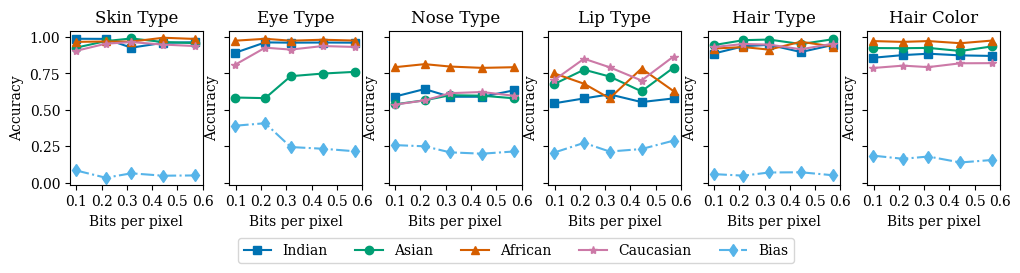

[0.17388713 0.03559859 0.06987702 0.03580732 0.03315311]
[0.29400827 0.36090572 0.33840693 0.17272808 0.20681433]
[0.3276634  0.20846838 0.23949014 0.17644509 0.23735235]
[0.20756183 0.21972605 0.23847457 0.2784305  0.21356859]
[0.25232825 0.04804842 0.04188457 0.06215573 0.12223866]
[0.17718581 0.18514845 0.17464477 0.18871926 0.1527032 ]


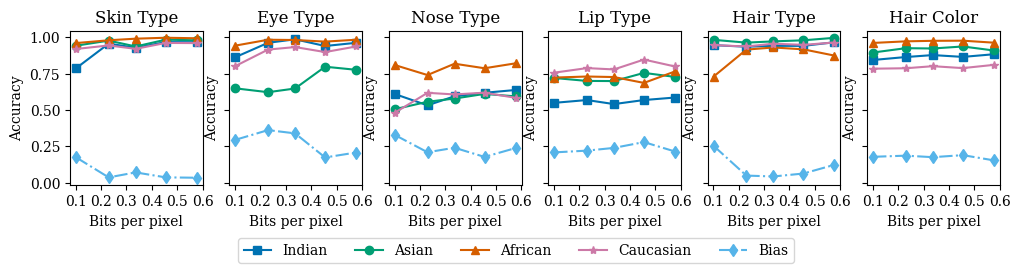

In [100]:
model = "qarv"
# hyperprior, mbt2018, cheng2020-attn, qres17m, qarv
temp, rates = generate_results(model=model)
ff_temp, ff_rates = generate_results("fairface", model=model)
results = get_clean_pred()
ff_results = get_clean_pred()
mpl.style.use('seaborn-v0_8-colorblind')
print(results)

def plot_races_and_fairness(temp, rates, results, trained_on, figure_name, write_image=False):
    fig, axes = plt.subplots(1, 6, figsize=(12, 2), sharey=True, sharex=True)
    axes = axes.flatten()
    
    #colors = ['b', 'y', 'g', 'r']
    
    for i, cat in enumerate(categories):
        zz = []
        axes[i].set_title(category_names[i])
        for j, race in enumerate(races):
            axes[i].plot(rates, temp[cat][race], marker=race_markers[j], label=race,) #color = colors[j],
            zz.append(temp[cat][race])
        #print(zz)
        axes[i].plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker="d", linestyle = "dashdot" , color = plt.rcParams['axes.prop_cycle'].by_key()['color'][5], label="Bias")
        print(np.array(zz).max(0) - np.array(zz).min(0))

        axes[i].set_xlabel("Bits per pixel")
        axes[i].set_ylabel("Accuracy")
        axes[i].set_xticks(np.arange(0.1, round(max(rates), 1)+0.1, 0.1))

    #for j, race in enumerate(races):
    #    for i, cat in enumerate(categories):
    #        axes[i%2][i//2].axhline(results[race][cat], linestyle="--", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j] )#color=colors[j])
    axes[0].legend(bbox_to_anchor=(5.5, -0.3), ncol = 5)
    fig.subplots_adjust(hspace=0.3)
    #plt.suptitle(model)
    if write_image:
        fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', model, f'{model}_{trained_on}_{figure_name}.png'), bbox_inches='tight',dpi=200)
        fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', model, f'{model}_{trained_on}_{figure_name}.pdf'), bbox_inches='tight', dpi=200)
    plt.show()
    
plot_races_and_fairness(temp, rates, results, 'celeba', 'racial_disparity', write_image=False)
plot_races_and_fairness(ff_temp, ff_rates, ff_results, 'fairface', 'racial_disparity', write_image=False)

In [101]:
def plot_races_and_fairness_single(temp, rates, results):
    categories = ["eye_type"]
    fig, axes = plt.subplots(len(categories), figsize=(2, 1.6), sharey=True)
    
    colors = ['b', 'y', 'g', 'r']
    # axes.set_title("Accuracy vs Rate (by Group)")
    for i, cat in enumerate(categories):
        zz = []

        for j, race in enumerate(races):
            axes.plot(rates, temp[cat][race], marker=race_markers[j], markersize=4, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], label=race)

            zz.append(temp[cat][race])
        axes.plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker="d", markersize=4, linestyle = "dashdot" , color = plt.rcParams['axes.prop_cycle'].by_key()['color'][5], label="Bias")
        #print(np.array(zz).max(0) - np.array(zz).min(0))

    # for j, race in enumerate(races):
    #     for i, cat in enumerate(categories):
    #         axes.axhline(results[race][cat], linestyle="--", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
    axes.set_xticks([0.1, 0.2, 0.3, 0.4])
    axes.legend(bbox_to_anchor=(1, 1))
    axes.set_xlabel("Bits per pixel")
    axes.set_ylabel("Accuracy")
    fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', model, f'{model}_celeba_eye_fairness.pdf'),bbox_inches='tight', dpi=200)
    plt.show()


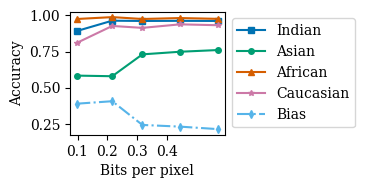

In [102]:
plot_races_and_fairness_single(temp, rates, results)
# todo: keep which - cheng, eye, celeba

### 3.3

In [103]:
def all_fairness(temp, rates, trained_on, write_image=False):
    fig, axes = plt.subplots(1, figsize=(2, 1.6), sharey=True)

    #colors = ['b', 'y', 'g', 'r', "darkviolet", "slategrey"]
    markers = ['s', 'o', '^', '*', "v", "P"]
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3)), (0, (5, 1))]

    # axes.set_title(f"Fairness, {model}, {trained_on}")
    
    for i, cat in enumerate(categories):
        zz = []
        for j, race in enumerate(races):
            #axes[i].plot(rates, temp[cat][race], marker=race_markers[j], color = colors[j], label=race)
            zz.append(temp[cat][race])
        axes.plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker=markers[i], markersize=4, linestyle=linestyles[i], label=category_names[i])
    axes.legend(bbox_to_anchor=(1, 1.05))
    axes.set_xlabel("Bits per pixel")
    axes.set_ylabel("Bias")
    axes.set_xticks([0.1, 0.2, 0.3, 0.4])

    #for j, race in enumerate(races):
    #    for i, cat in enumerate(categories):
    #        axes[i].axhline(results[race][cat], linestyle="--", color=colors[j])
    figure_name= 'all_fairness'
    if write_image:
        fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', model, f'{model}_{trained_on}_{figure_name}.png'), bbox_inches='tight', dpi=200)
        fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', model, f'{model}_{trained_on}_{figure_name}.pdf'), bbox_inches='tight', dpi=200)
        
    plt.show()

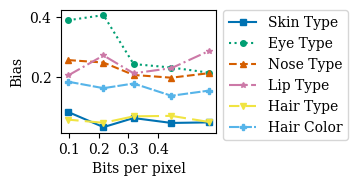

In [104]:
all_fairness(temp, rates, 'celeba', write_image=False)

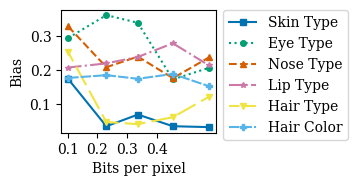

In [105]:
all_fairness(ff_temp, ff_rates, 'fairface', write_image=False)

In [106]:
def plot_fairness_comparison(temp, ff_temp, rates, write_image=False):
    categories = ["skin_type", "eye_type", "hair_color"]
    fig, axes = plt.subplots(1, figsize=(2.5, 2), sharey=True)
    markers = ['s', 'o', '^', '*', "v", "D"]

    # axes.set_title(f"FairFace/celebA Comparison, {model}")
    
    for i, cat in enumerate(categories):
        zz = []
        yy = []
        for j, race in enumerate(races):
            #axes[i].plot(rates, temp[cat][race], marker=race_markers[j], color = colors[j], label=race)
            zz.append(temp[cat][race])
            yy.append(ff_temp[cat][race])
        axes.plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker=markers[i],  linestyle = "-", label=f"{category_names[i]} (CelebA)", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        axes.plot(rates, np.array(yy).max(0) - np.array(yy).min(0), marker=markers[i], linestyle = "--", label=f"{category_names[i]} (FairFace)", color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    axes.legend(bbox_to_anchor=(1.05, 1))
    axes.set_xlabel("Bits per pixel")
    axes.set_ylabel("Bias")
    # axes.set_xticks([0.1, 0.2, 0.3, 0.4])
        #print(np.array(zz).max(0) - np.array(zz).min(0))
    
        
    #for i, cat in enumerate(categories):
       # max_acc = 0
       # min_acc = 1
       # for j, race in enumerate(races):
       #     value = results[race][cat]
       #     if value > max_acc:
                #max_acc = value
       #     if value < min_acc:
                #min_acc = value
        #axes[i].axhline(max_acc - min_acc, linestyle="--", color=colors[j])
    if write_image:
        fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', model, f'{model}_dataset_comp.png'), bbox_inches='tight', dpi=200)
        fig.savefig(os.path.join('../../plots/new_training_merge_skin_hair_type_color', model, f'{model}_dataset_comp.pdf'), bbox_inches='tight', dpi=200)
    
    plt.show()

In [107]:
def compute_fairness(temp, ff_temp): 
    model_fairness = {}
    model_fairness["celebA"] = {}
    model_fairness["fairface"] = {}
    for i, cat in enumerate(categories):
        zz = []
        yy = []
        for j, race in enumerate(races):
            zz.append(temp[cat][race])
            yy.append(ff_temp[cat][race])
        model_fairness["celebA"][cat] = (np.array(zz).max(0) - np.array(zz).min(0)).tolist()
        model_fairness["fairface"][cat] = (np.array(yy).max(0) - np.array(yy).min(0)).tolist()
    return model_fairness
    

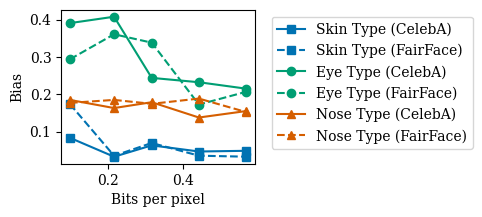

In [108]:
plot_fairness_comparison(temp, ff_temp, rates, write_image=True)

In [109]:
# generate and save bias numbers
# model_list = ["hyperprior", "qres17m", "cheng2020-attn", "mbt2018", "qarv"]

# all_fairness = {}
# for model in model_list:
#    temp, rates = generate_results(model=model)
#    ff_temp, ff_rates = generate_results("fairface", model=model)
#    all_fairness[model] = compute_fairness(temp, ff_temp)
# all_fairness


In [110]:
## Dump Fairness value to json

# import json
# with open('sep_fairness_new.json', 'w') as fp:
#    json.dump(all_fairness, fp)